Using v2 dataset. 80/20 split, no separate test. Time-based split.

In [1]:
from pathlib import Path

# import * appears to be the fast.ai way of doing things,
# even though every instinct in me says "don't do this" :)
from fastai.vision import *  
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [2]:
path = Path("~/data/split-v2-time").expanduser()

In [3]:
data = ImageDataBunch.from_folder(path, bs=32)

It seems to be already normalized (check with `data.one_batch(DatasetType.Train)`)

This loads a model with pretrained weights (imagenet?), custom head, everything is frozen apart from the head.

In [4]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy, ps=.6)

Dropout control with `ps`, default is .5.
I think it is like keras: the probability to zero out inputs.

In [5]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


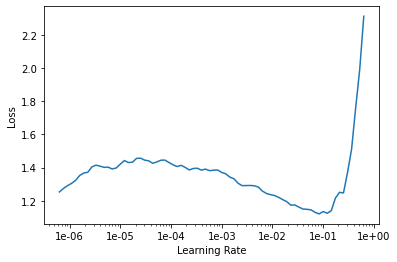

In [6]:
learn.recorder.plot()

In [7]:
learn.fit_one_cycle(2, 0.02)

epoch,train_loss,valid_loss,accuracy,time
0,0.396010,0.361983,0.892558,11:19
1,0.121566,0.124515,0.943256,13:04


In [8]:
learn.save("model-fastai-2-time-2epochs")

In [9]:
learn.unfreeze()
learn.data.batch_size = 28
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


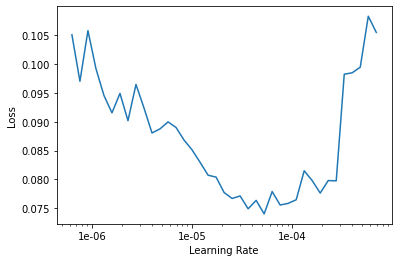

In [10]:
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(2, max_lr=[2e-6, 1e-5, 2e-5])

epoch,train_loss,valid_loss,accuracy,time
0,0.087025,0.124574,0.947907,14:16
1,0.066601,0.089615,0.966047,14:12


In [12]:
learn.save("model-fastai-2-time-2epochs-plus2unfrozen")

In [13]:
learn.fit_one_cycle(2, max_lr=[2e-6, 1e-5, 2e-5])

epoch,train_loss,valid_loss,accuracy,time
0,0.054956,0.067368,0.973023,14:10
1,0.041234,0.076332,0.972558,14:10


In [21]:
learn.save("model-fastai-2-time-2epochs-plus4unfrozen")

This might be all we can get before overfitting. Still quite good.

In [14]:
pred_train = learn.get_preds(ds_type=DatasetType.Train)

In [15]:
accuracy(*pred_train)

tensor(0.9949)

In [16]:
pred_cv = learn.get_preds(ds_type=DatasetType.Valid)

In [17]:
accuracy(*pred_cv)

tensor(0.9726)

In [25]:
np.unique(pred_train[1], return_counts=True)

(array([0, 1]), array([7236, 1360]))

In [18]:
def sklearn_metrics(preds_output):
    preds, labels = preds_output
    pred_classes = (preds > .5).numpy().astype(int)[:, 1]
    
    acc = accuracy_score(labels, pred_classes)
    prec = precision_score(labels, pred_classes)
    recall = recall_score(labels, pred_classes)
    f1 = 2 * prec * recall / (prec + recall)

    print(f"Accuracy:  {acc:.3f}")  # Sanity check
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1:        {f1:.3f}")

In [19]:
sklearn_metrics(pred_train)

Accuracy:  0.995
Precision: 0.978
Recall:    0.990
F1:        0.984


In [20]:
sklearn_metrics(pred_cv)

Accuracy:  0.973
Precision: 0.861
Recall:    0.985
F1:        0.919


Low-ish precision means that we are getting false positives while predicting BirdRoaming. About 1 in 9.
So sometimes we think the bird is roaming, while it's actually still there. Would be nice to get this a bit higher.

In any case, I might be able to handle this by smoothening the predictions over time.